# Clustering Analysis

Analysis of the pre and post files of the CTI. 
It runs a k-means algorithm on the ACESTEM variables for the pre and post files.

In [1]:
# Imports
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

In [2]:
random.seed(2022)
np.random.seed(2022)

## Pre

In [3]:
link = "data/2021_Alumnos_pre_red.csv"
data = pd.read_csv(link)
data.head()

,Codigo,Edad,Nivel,Genero,Gusto,Interes_profesional,Autoeficacia,Utilidad
0,108472,13,SENIOR,Chico,3.833333,3.166667,4.25,3.8
1,612000,14,SENIOR,Chica,4.166667,3.500000,4.75,4.6
2,812078,15,SENIOR,Chico,4.166667,4.833333,3.00,4.8
3,902236,14,SENIOR,Chica,4.333333,3.666667,3.50,4.0
4,1107000,16,SENIOR,Chico,3.000000,3.000000,3.00,3.0


Data for the clustering analysis

In [4]:
acestem = data[["Gusto", "Interes_profesional", "Autoeficacia", "Utilidad"]]

### Bin according to Age and Gender

In [5]:
def categorise(row):  
    if row['Edad'] <= 12:
        return 'Younger student'
    elif row['Edad'] > 12:
        return 'Older student'
    return 'Error'

In [6]:
data["Grupo_Edad"] = data.apply(lambda row: categorise(row), axis=1)

### Scaling

In [7]:
# #scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(acestem)

### Optimal Number of Clusters

Parameters:

- **init** controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence.

- **n_clusters** sets k for the clustering step. This is the most important parameter for k-means.

- **n_init** sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

- **max_iter** sets the number of maximum iterations for each initialization of the k-means algorithm.

In [8]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

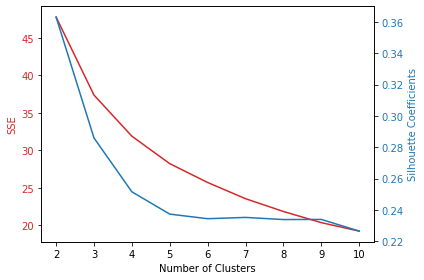

In [9]:
x = range(2,11)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('SSE', color=color)
ax1.plot(x, sse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette Coefficients', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouette_coefficients, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Looking at both meassures, the optimal number of clusters is between 3 and 4 clusters

### K-Means Clustering k = 3

In [10]:
In [7]: kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42)

In [11]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [12]:
data["label"] = kmeans.labels_
data.head()

,Codigo,Edad,Nivel,Genero,Gusto,Interes_profesional,Autoeficacia,Utilidad,Grupo_Edad,label
0,108472,13,SENIOR,Chico,3.833333,3.166667,4.25,3.8,Older student,2
1,612000,14,SENIOR,Chica,4.166667,3.500000,4.75,4.6,Older student,2
2,812078,15,SENIOR,Chico,4.166667,4.833333,3.00,4.8,Older student,0
3,902236,14,SENIOR,Chica,4.333333,3.666667,3.50,4.0,Older student,2
4,1107000,16,SENIOR,Chico,3.000000,3.000000,3.00,3.0,Older student,1


### Cluster composition

In [13]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['Gusto', 'Interes_profesional', 'Autoeficacia', 'Utilidad'])
centers

,Gusto,Interes_profesional,Autoeficacia,Utilidad
0,0.916667,0.892906,0.773760,0.878306
1,0.425926,0.362037,0.502083,0.646667
2,0.746196,0.619467,0.642894,0.791909


- **Cluster 0** : students who have high scores in all ACESTEM variables
- **Cluster 1** : students who have low scores in all ACESTEM variables
- **Cluster 2**: students who have medium scores in all ACESTEM variables

### Representation

In [14]:
data.label.value_counts().sort_index()

0    242
1     90
2    241
Name: label, dtype: int64

<AxesSubplot: >

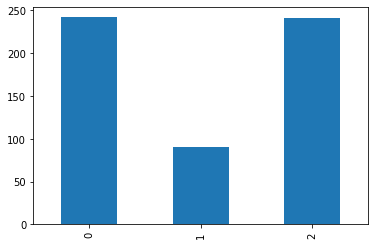

In [15]:
data.label.value_counts().sort_index().plot(kind = 'bar')

- Most students belong to cluster 0 (242) and 2 (241) (high and medium ACESTEM scores)
    - Expected because students who attend a science camp tend to have high ACESTEM scores
- Few students belong to cluster 1 (90)

#### Gender distribution

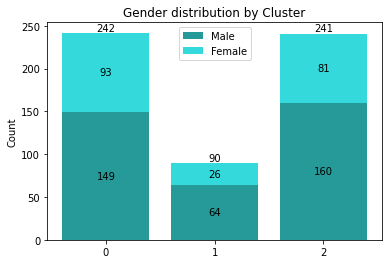

In [16]:
labels = ['0', '1', '2']
men = data[data.Genero == 'Chico'].label.value_counts().sort_index().values
women = data[data.Genero == 'Chica'].label.value_counts().sort_index().values

# width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(labels, men, label='Male' , color=(0.15, 0.6, 0.6))
p2 = ax.bar(labels, women, bottom=men, label='Female', color=(0.2, 0.85, 0.86))

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

ax.set_ylabel('Count')
ax.set_title('Gender distribution by Cluster')
ax.legend()

plt.show()

#### Age Distribution

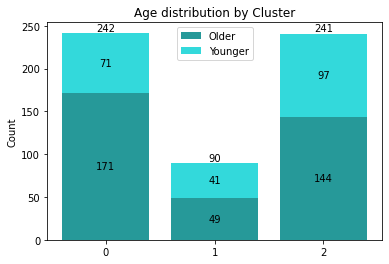

In [17]:
labels = ['0', '1', '2']

older = data[data.Grupo_Edad == 'Older student'].label.value_counts().sort_index().values
younger = data[data.Grupo_Edad == 'Younger student'].label.value_counts().sort_index().values

# width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(labels, older, label='Older', color=(0.15, 0.6, 0.6))
p2 = ax.bar(labels, younger, bottom=older, label='Younger', color=(0.2, 0.85, 0.86))

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

ax.set_ylabel('Count')
ax.set_title('Age distribution by Cluster')
ax.legend()

plt.show()

#### Cluster Representation

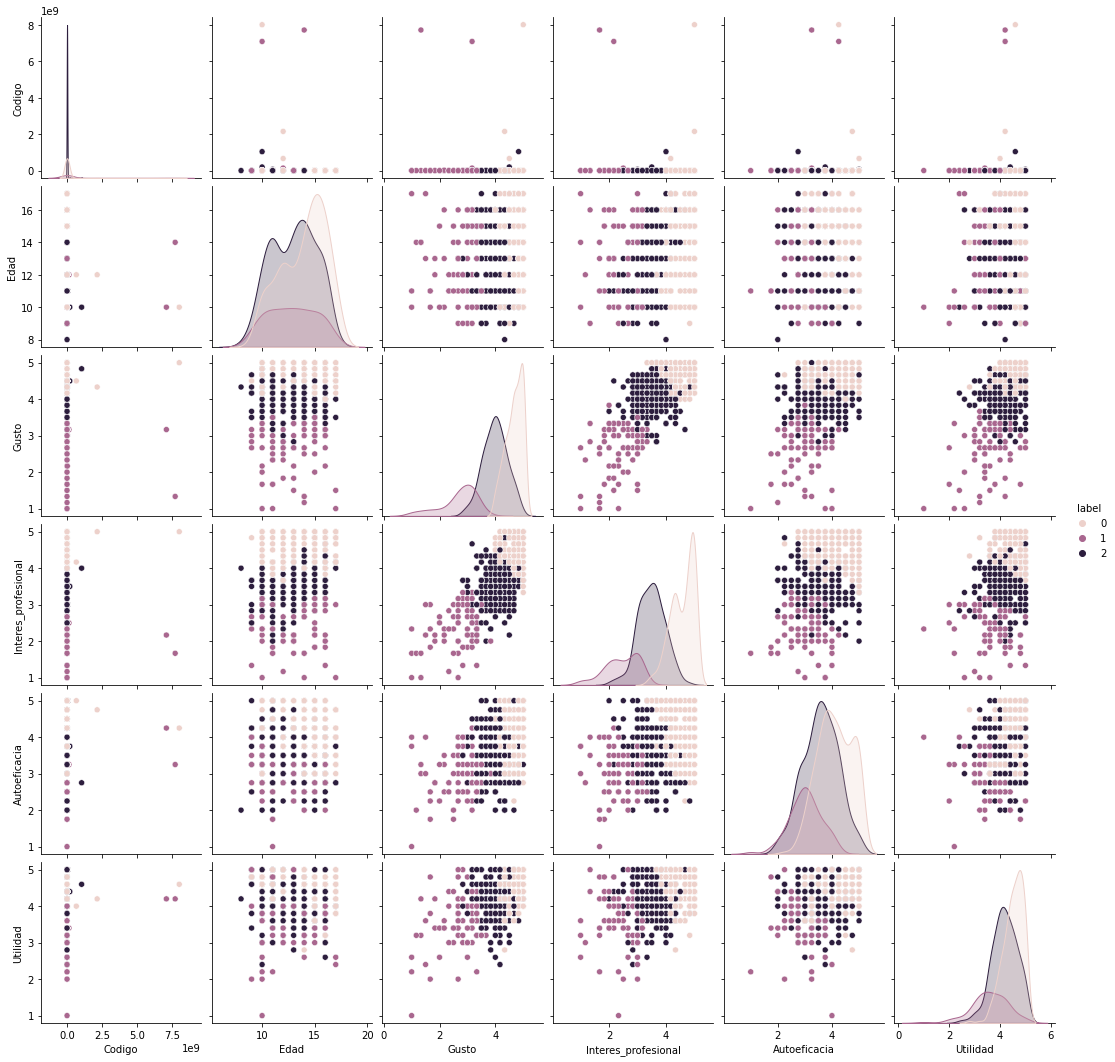

In [18]:
sns.pairplot(data, hue ='label')

### Save Clusters

In [19]:
data.to_csv("data/2021_pre_clusters.csv", index = False)

## Post

In [20]:
link = "data/2021_Alumnos_post_red.csv"
data = pd.read_csv(link)
data.head()

,Codigo,Nivel,Genero,Gusto,Interes_profesional,Autoeficacia,Utilidad
0,108472.0,SENIOR,Chico,3.333333,3.166667,4.50,3.8
1,401577.0,SENIOR,Chica,5.000000,5.000000,4.75,4.4
2,611283.0,SENIOR,Chica,3.666667,3.333333,4.75,4.6
3,902236.0,SENIOR,Chica,4.333333,4.000000,3.75,4.0
4,1107156.0,SENIOR,Chico,4.666667,5.000000,4.50,4.2


In [21]:
acestem = data[["Gusto", "Interes_profesional", "Autoeficacia", "Utilidad"]]

### Scaling

In [22]:
# #scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(acestem)

### Optimal Number of Clusters

Parameters:

- **init** controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence.

- **n_clusters** sets k for the clustering step. This is the most important parameter for k-means.

- **n_init** sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

- **max_iter** sets the number of maximum iterations for each initialization of the k-means algorithm.

In [23]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

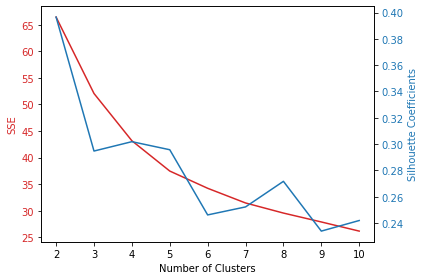

In [24]:
x = range(2,11)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('SSE', color=color)
ax1.plot(x, sse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette Coefficients', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouette_coefficients, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

For this dataset, according to the sse and silhouette metrics, it appears that 5 is the best number of clusters. We will analyze 3 and 5 clusters in order to both stay consistent with the results of the pre analysis and test this new solution.

### K-Means Clustering k = 3

In [25]:
In [7]: kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42)

In [26]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [27]:
data["label"] = kmeans.labels_
data.head()

,Codigo,Nivel,Genero,Gusto,Interes_profesional,Autoeficacia,Utilidad,label
0,108472.0,SENIOR,Chico,3.333333,3.166667,4.50,3.8,1
1,401577.0,SENIOR,Chica,5.000000,5.000000,4.75,4.4,0
2,611283.0,SENIOR,Chica,3.666667,3.333333,4.75,4.6,1
3,902236.0,SENIOR,Chica,4.333333,4.000000,3.75,4.0,1
4,1107156.0,SENIOR,Chico,4.666667,5.000000,4.50,4.2,0


### Cluster Composition

In [28]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['Gusto', 'Interes_profesional', 'Autoeficacia', 'Utilidad'])
centers

,Gusto,Interes_profesional,Autoeficacia,Utilidad
0,0.941851,0.910338,0.820609,0.908861
1,0.781806,0.663611,0.623125,0.816667
2,0.474237,0.386132,0.483302,0.640458


The groups are the same but the scores are higher

### Representation

In [29]:
data.label.value_counts().sort_index()

0    316
1    300
2    131
Name: label, dtype: int64

<AxesSubplot: >

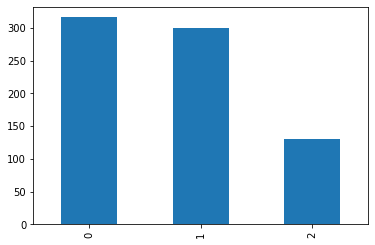

In [30]:
data.label.value_counts().sort_index().plot(kind = 'bar')

### Gender distribution

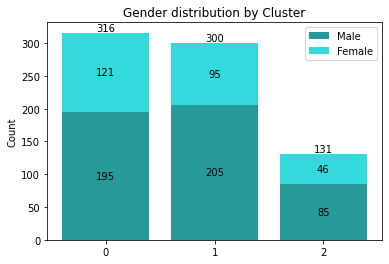

In [31]:
labels = ['0', '1', '2']
men = data[data.Genero == 'Chico'].label.value_counts().sort_index().values
women = data[data.Genero == 'Chica'].label.value_counts().sort_index().values

# width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(labels, men, label='Male' , color=(0.15, 0.6, 0.6))
p2 = ax.bar(labels, women, bottom=men, label='Female', color=(0.2, 0.85, 0.86))

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

ax.set_ylabel('Count')
ax.set_title('Gender distribution by Cluster')
ax.legend()

plt.show()

### Level Distribution

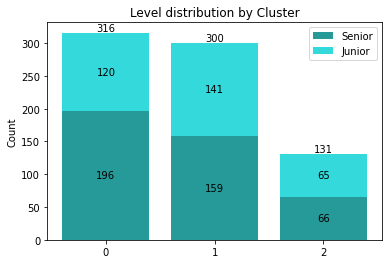

In [32]:
labels = ['0', '1', '2']

older = data[data.Nivel == 'SENIOR'].label.value_counts().sort_index().values
younger = data[data.Nivel == 'JUNIOR'].label.value_counts().sort_index().values

# width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(labels, older, label='Senior', color=(0.15, 0.6, 0.6))
p2 = ax.bar(labels, younger, bottom=older, label='Junior', color=(0.2, 0.85, 0.86))

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

ax.set_ylabel('Count')
ax.set_title('Level distribution by Cluster')
ax.legend()

plt.show()

### Cluster Representation

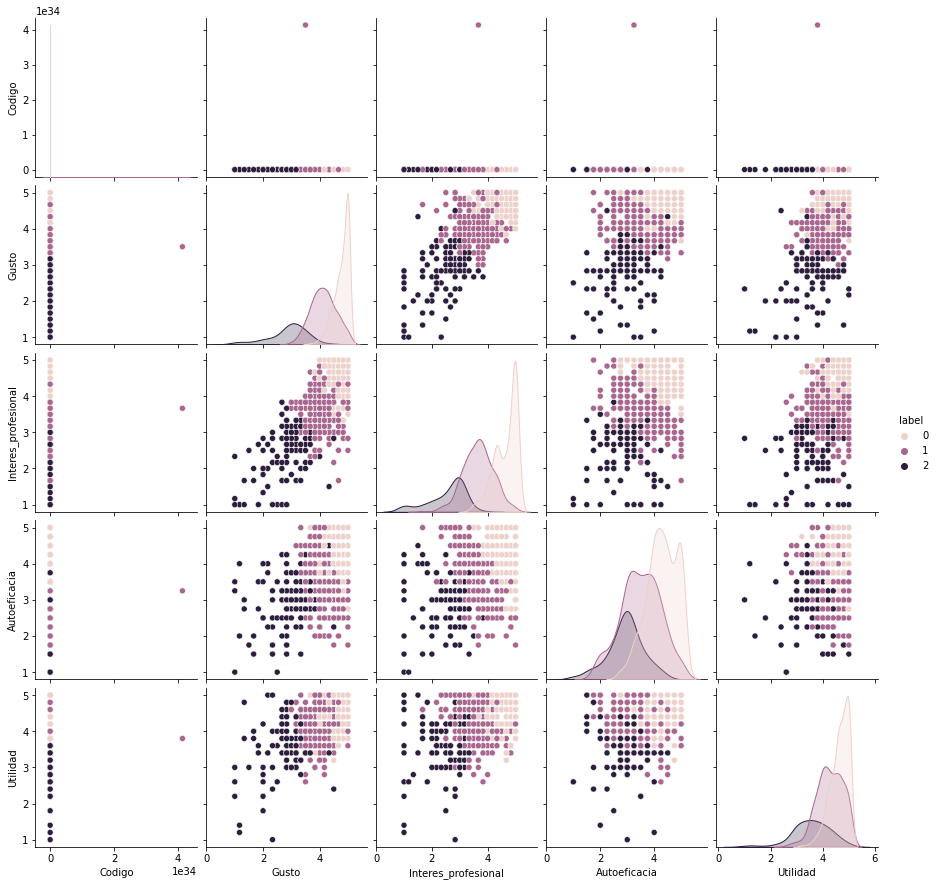

In [33]:
sns.pairplot(data, hue ='label')

### Save clusters

In [34]:
data.to_csv("data/2021_post_clusters.csv", index = False)

### K-Means Clustering k = 5

In [35]:
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=42)

kmeans.fit(scaled_features)

data["label"] = kmeans.labels_
data.head()

,Codigo,Nivel,Genero,Gusto,Interes_profesional,Autoeficacia,Utilidad,label
0,108472.0,SENIOR,Chico,3.333333,3.166667,4.50,3.8,1
1,401577.0,SENIOR,Chica,5.000000,5.000000,4.75,4.4,4
2,611283.0,SENIOR,Chica,3.666667,3.333333,4.75,4.6,1
3,902236.0,SENIOR,Chica,4.333333,4.000000,3.75,4.0,1
4,1107156.0,SENIOR,Chico,4.666667,5.000000,4.50,4.2,4


### Cluster Composition

In [36]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['Gusto', 'Interes_profesional', 'Autoeficacia', 'Utilidad'])
centers

,Gusto,Interes_profesional,Autoeficacia,Utilidad
0,0.276709,0.202991,0.456731,0.578205
1,0.785610,0.611676,0.787427,0.811337
2,0.879032,0.828226,0.525000,0.876129
3,0.599826,0.527778,0.486979,0.699306
4,0.952532,0.927567,0.864188,0.917722


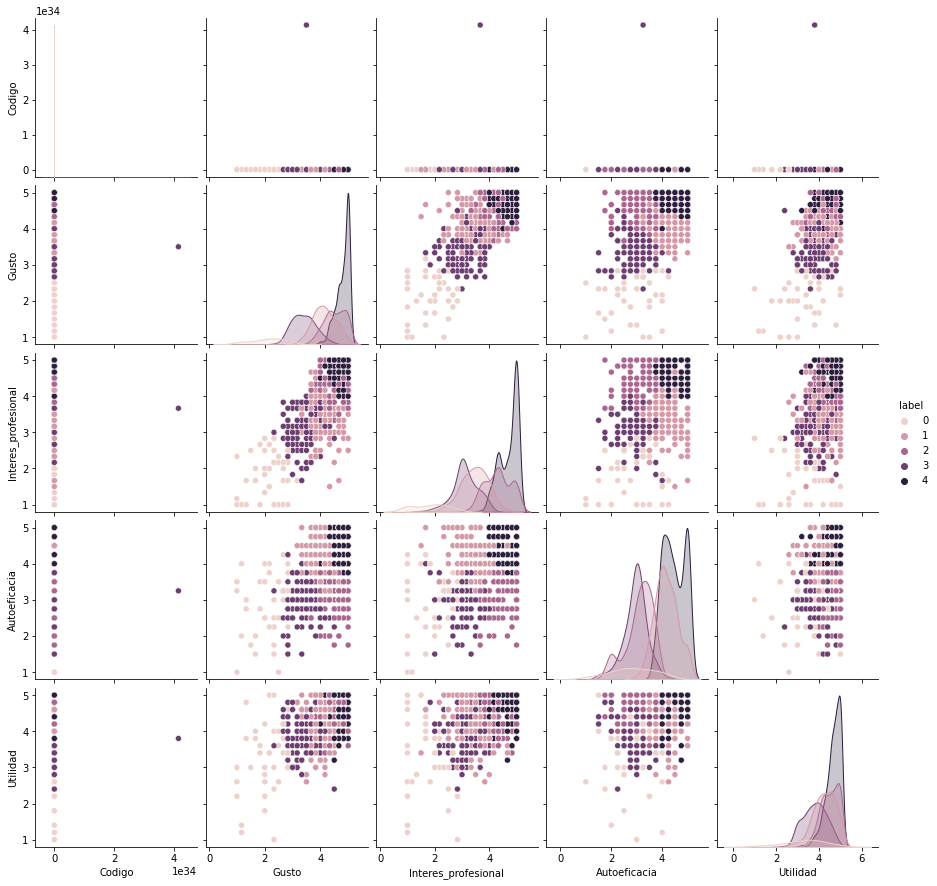

In [37]:
sns.pairplot(data, hue ='label')

- **Cluster 0** : students who have low scores in all ACESTEM variables
- **Cluster 1** : students who have medium scores in all ACESTEM variables but slightly lower professional interest
- **Cluster 2**: students who have medium scores in all ACESTEM variables except lower self-efficacy
- **Cluster 3**: students who have low scores in all ACESTEM variables but higher passion and professional interest compared to cluster 0
- **Cluster 4**: students who have high scores in all ACESTEM variables

## Flow Diagram

We are going to create a flow diagram that shows the flow from pre clusters to post clusters. Since the same student can appear several times in the dataset if they have attended more than one course, we will keep the first pre instance and the last post instance.

In [38]:
pre = pd.read_csv("data/2021_pre_clusters.csv")
pre = pre.drop_duplicates(subset = 'Codigo')
pre = pre[["Codigo", "label"]]
pre.head()

,Codigo,label
0,108472,2
1,612000,2
2,812078,0
3,902236,2
4,1107000,1


In [39]:
post = pd.read_csv("data/2021_post_clusters.csv")
post = post.drop_duplicates(subset = 'Codigo', keep = 'last')
post = post[["Codigo", "label"]]
post.head()

,Codigo,label
2,611283.0,1
3,902236.0,1
4,1107156.0,0
9,2308161.0,0
10,2409000.0,1


In [40]:
pre_post = pre.merge(post, on = 'Codigo')
pre_post

C:\Users\Maria\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,Codigo,label_x,label_y
0,108472,2,2
1,902236,2,1
2,1107000,1,1
3,1107156,0,0
4,1711134,0,0
...,...,...,...
333,2101024,0,0
334,2703000,2,1
335,2908377,1,2
336,2912000,0,0


In [41]:
count = pre_post[["label_x", "label_y"]].value_counts().sort_index()
count

label_x  label_y
0        0          114
         1           38
         2            2
1        0            3
         1            8
         2           35
2        0           26
         1           93
         2           19
dtype: int64

In [42]:
count.index

MultiIndex([(0, 0),
            (0, 1),
            (0, 2),
            (1, 0),
            (1, 1),
            (1, 2),
            (2, 0),
            (2, 1),
            (2, 2)],
           names=['label_x', 'label_y'])

In [65]:
source = []
target = []
value = []
for i in range(len(count)):
    source.append(count.index[i][0])
    target.append(count.index[i][1] + 3)
    value.append(count.values[i])

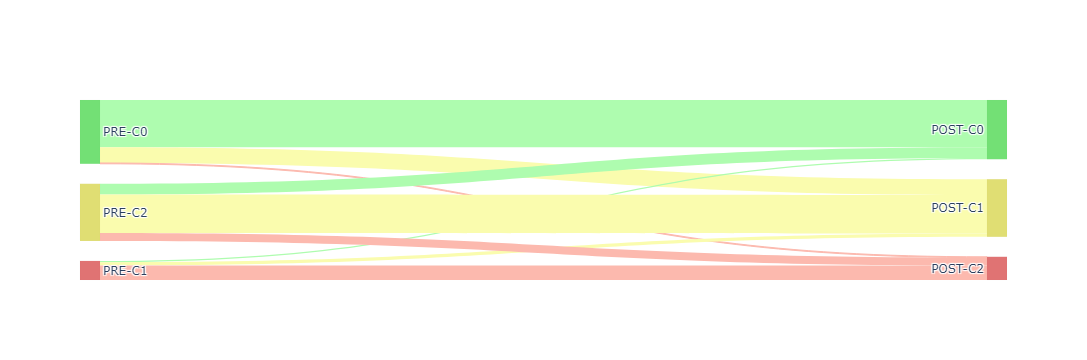

In [91]:
color_link = ['#AEFCAF', '#FAFCAE', '#FCB9AE', '#AEFCAF','#FAFCAE', '#FCB9AE', '#AEFCAF', '#FAFCAE','#FCB9AE']
link = dict(source = source, target = target, value = value, color = color_link)

label = ["PRE-C0", "PRE-C1", "PRE-C2", "POST-C0", "POST-C1", "POST-C2"]
color_node = ['#73E075','#E07373','#E0DE73','#73E075','#E0DE73','#E07373']
line = dict(color = None, width = 0.01)
node = dict(label = label, color = color_node, line = line)

data = go.Sankey(link = link, node =  node)

fig = go.Figure(data)

fig.show()